# Reading the ROOT files

In [418]:
# %matplotlib notebook

In [749]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer
from keras.preprocessing import sequence

In [750]:
import uproot
import numpy as np
# import pandas as pd

In [751]:
import matplotlib.pyplot as plt
import awkward as ak
from mpl_toolkits.mplot3d import axes3d 
from matplotlib.colors import LogNorm
import IPython

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [42]:
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

In [587]:
fastn = uproot.open('data/fastn2.root'+':data')
sing = uproot.open('data/singles.root'+':data')
eplus = uproot.open('data/e+.root'+':data')
eminus = uproot.open('data/e-.root'+':data')
fastnsing = uproot.open('data/fastn_singles.root'+':data')

In [592]:
neutrons = fastn.arrays(library='awkward')
singles = sing.arrays(library='awkward')#[:20000]
positrons = eplus.arrays(library='awkward')[50000:150000]
electrons = eminus.arrays(library='awkward')[50000:150000]
# singles['channel']=singles['channel']-1 #need to reprocess..

In [378]:
nsing = fastnsing.arrays(library='awkward')
moresingles = nsing[nsing['code']==4]
moreneutrons = nsing[nsing['code']==2]

In [379]:
singles = ak.concatenate([singles, moresingles])
neutrons = ak.concatenate([neutrons, moreneutrons])

In [593]:
neutrons = neutrons[neutrons['inner_hit']>0]

In [12]:
# chargeprob = {
# 'charge' : [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000],
# 'charge_prob' : [2.320677e-02, 4.744035e-02, 8.994838e-02, 1.581799e-01, 2.580009e-01, 3.903046e-01, 5.476440e-01, 7.126976e-01, 8.602498e-01, 9.630662e-01, 1.000000e+00, 9.630662e-01, 8.602498e-01, 7.126976e-01, 5.476440e-01, 3.903046e-01, 2.580009e-01, 1.581799e-01, 8.994838e-02, 4.744035e-02, 2.320677e-02, 1.052916e-02, 4.430830e-03, 1.729373e-03, 6.260438e-04, 2.102001e-04, 6.545962e-05, 1.890716e-05, 5.065140e-06, 1.258545e-06, 2.900404e-07, 6.199556e-08, 1.229065e-08, 2.259964e-09, 3.854254e-10]
# }
# mu, sig = norm.fit(wht)
# inv_cdf = interpolate.interp1d(chargeprob['charge_prob'], chargeprob['charge'])
# x = np.random.rand(100000)
# wht = inv_cdf(x)

In [531]:
pmtx = pmtpos[:,0]
pmty = pmtpos[:,1]
pmtz = pmtpos[:,2]

In [532]:
vx = data['x']/10.
vy = data['y']/10.
vz = data['z']/10.


In [522]:
pmtx = ak.from_numpy(pmtx)

In [523]:
pmtxpos = []

In [527]:
for i, ht in enumerate(data['hittime']): 
    if i%10_000==0:
        print('-----Processing sample %i of %i-----'%(i, len(data)))
    pmtxpos.append(pmtx[data['channel'][0]])

-----Processing sample 0 of 221519-----
-----Processing sample 10000 of 221519-----
-----Processing sample 20000 of 221519-----
-----Processing sample 30000 of 221519-----
-----Processing sample 40000 of 221519-----
-----Processing sample 50000 of 221519-----
-----Processing sample 60000 of 221519-----
-----Processing sample 70000 of 221519-----


KeyboardInterrupt: 

In [567]:
data['restime'][i]

<Array [347, 411, 417, ... 1.56e+03, 1.73e+03] type='50 * float32'>

In [578]:
ak.Array()

TypeError: __init__() got an unexpected keyword argument 'dtype'

In [594]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([neutrons, singles, positrons]):
    data['restime'] = data['hittime']
    print('set %i of %i'%(j+1, 3))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]
    
#         #Calculate residual time from vertex? 
#         chn = data['channel'] 
#         times = data['hittime']-800.
#         for i, time in enumerate(times): 
#             if i%10_000==0:
#                 print('-----Processing sample %i of %i-----'%(i, len(data)))
#             xyz = pmtpos[chn[i]] #cm
#             vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.] #cm
#             dist = np.sqrt(np.sum((xyz - vertex)**2, axis=1)) # cm
#             res = time - dist/c
#             data['restime'][i] = res

set 1 of 3
set 2 of 3
set 3 of 3


In [595]:
delaytime = 800
c = 21.8 #cm/ns

for j, data in enumerate([neutrons, singles, positrons]):
    channels = []
    charges = []
    timess = []
    chn = data['channel']    
    print('set %i of %i'%(j+1, 3))
    times = data['hittime']-800.
    for i, ht in enumerate(data['hittime']): 
        if i%10_000==0:
            print('-----Processing sample %i of %i-----'%(i, len(data)))
        xyz = pmtpos[chn[i]] #cm
        vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.] #cm
        dist = np.sqrt(np.sum((xyz - vertex)**2, axis=1)) # cm
        res = times[i] - dist/c
        promptmask = np.logical_and(res<delaytime, res>-1*delaytime)
#         median = med(ht)
#         ht = np.asarray(ht)
#         promptmask = np.logical_and(ht>median-delaytime, ht<median+delaytime)
        channels.append(data['channel'][i][promptmask])
        charges.append(data['pmtcharge'][i][promptmask])
        timess.append(res[promptmask])
    data['promptchan'], data['promptcharge'], data['prompttime'] = ak.Array(channels), ak.Array(charges), ak.Array(timess)

set 1 of 3
-----Processing sample 0 of 21433-----
-----Processing sample 10000 of 21433-----
-----Processing sample 20000 of 21433-----
set 2 of 3
-----Processing sample 0 of 44400-----
-----Processing sample 10000 of 44400-----
-----Processing sample 20000 of 44400-----
-----Processing sample 30000 of 44400-----
-----Processing sample 40000 of 44400-----
set 3 of 3
-----Processing sample 0 of 100000-----
-----Processing sample 10000 of 100000-----
-----Processing sample 20000 of 100000-----
-----Processing sample 30000 of 100000-----
-----Processing sample 40000 of 100000-----
-----Processing sample 50000 of 100000-----
-----Processing sample 60000 of 100000-----
-----Processing sample 70000 of 100000-----
-----Processing sample 80000 of 100000-----
-----Processing sample 90000 of 100000-----


Previously was doing hittime for the good results. Now trying prompttime. Both give similar-ish results. 

Note: feeding channel probably means we're just capturing on the length of the vector and cutting there. Should compare ROC curve from this to the number of hits. 

In [596]:
samples = np.min([len(singles), len(positrons)])

In [73]:
wht_n = sequence.pad_sequences(neutrons['promptcharge'], maxlen=100)[:samples]
wht_s = sequence.pad_sequences(singles['promptcharge'], maxlen=100)[:samples]
wht_e = sequence.pad_sequences(positrons['promptcharge'], maxlen=100)[:samples]

In [74]:
# X2 = ak.concatenate([singles['prompttime'][:int(len(neutrons))], neutrons['prompttime']])

In [76]:
X = np.append(wht_s, wht_e, axis=0)
y = np.append(np.zeros(len(wht_s)), np.ones(len(wht_e)))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [365]:
# X_train2 = ak.to_list(X_train)
# X_test2 = ak.to_list(X_test)
# y_train2 = list(y_train)
# y_test2 = list(y_test)

In [123]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(2331, 
                    embedding_vecor_length, 
                    input_length=100)
         )
model.add(LSTM(100))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           74592     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 127,893
Trainable params: 127,893
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=3, batch_size=64, 
         )

Epoch 1/3
16/16 [==============================] - 4s 151ms/step - loss: 0.6822 - accuracy: 0.5598 - val_loss: 0.6178 - val_accuracy: 0.9039
Epoch 2/3
16/16 [==============================] - 2s 110ms/step - loss: 0.5528 - accuracy: 0.8984 - val_loss: 0.2287 - val_accuracy: 0.9611
Epoch 3/3
16/16 [==============================] - 2s 104ms/step - loss: 0.2436 - accuracy: 0.9213 - val_loss: 0.1413 - val_accuracy: 0.9468


In [125]:
y_pred = model.predict_classes(X_test)
scores = model.predict(X_test)

/home/sophiafarrell/.local/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [140]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

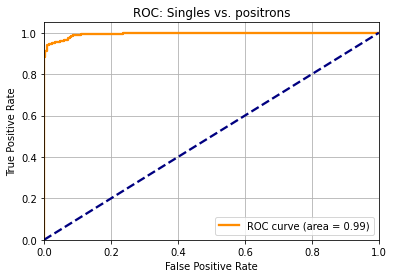

In [152]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.2f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. positrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
plt.show()

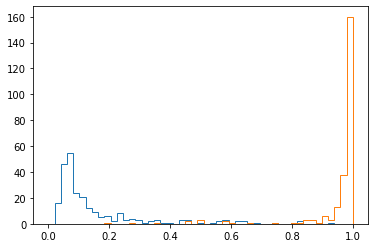

In [126]:
bins = plt.hist(model.predict(X_test[y_test==0]), 
         bins=np.linspace(0,1,50), histtype='step')
plt.hist(model.predict(X_test[y_test==1]), 
         bins=bins[1], histtype='step')
plt.show()

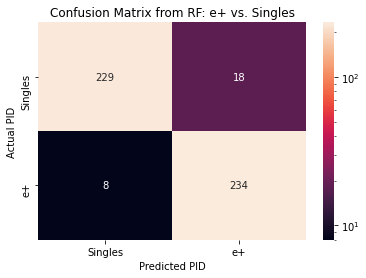

In [127]:
confmat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
                 norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: e+ vs. Singles')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['Singles', 'e+'])
ax.yaxis.set_ticklabels(['Singles', 'e+'])

plt.show()

------

In [692]:
def prep_net_data(data_to_manipulate, prompt=True, maxlen=100):
    X = []
    y = np.array([])
    
    if prompt==True:
        keys = ['promptchan', 'promptcharge', 'prompttime']
    else:
        keys = ['channel', 'pmtcharge', 'hittime']
        
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, 5))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        xyz = pmtpos[chn]+1
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz+1
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))    
    return X, y

## Multiple Regressor

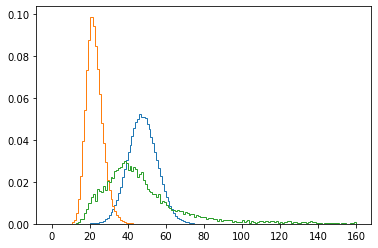

In [285]:
bins = plt.hist(positrons['id_plus_dr_hit'], histtype='step', bins=np.linspace(0, 160, 161), density=True)
plt.hist(singles['id_plus_dr_hit'], histtype='step', bins=bins[1], density=True)
plt.hist(neutrons['id_plus_dr_hit'], histtype='step', bins=bins[1], density=True)

plt.show()

In [597]:
samples = np.min([len(singles), len(positrons)])

In [598]:
data_to_manipulate = [singles[:samples], positrons[:samples]]

In [599]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',')
pmtpos = np.vstack((np.array([0, 0, 0]), pmtpos))

In [ ]:
X, y = prep_net_data(data_to_manipulate, promp=True)

In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [602]:
embedding_vecor_length = 64
regressor = Sequential()

regressor.add(InputLayer(input_shape=(100,5)))
regressor.add(LSTM(units=100, 
                   return_sequences=True, 
                   dropout=0.2,
                  )) #second arg seems to have huge effect. 

regressor.add(LSTM(units=100, 
                   return_sequences=False, 
                   dropout=0.2, 
                   
                  ))

regressor.add(Dense(1, activation='sigmoid'))

regressor.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [603]:
regressor.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 100, 100)          42400     
_________________________________________________________________
lstm_62 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


In [604]:
regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=1, batch_size=64, 
         )

1041/1041 [==============================] - 239s 227ms/step - loss: 0.2532 - accuracy: 0.8504 - val_loss: 0.0623 - val_accuracy: 0.9786


In [609]:
scores = regressor.predict(X_test)
# y_pred = regressor.predict_classes(X_test)
y_pred = np.round(scores)

In [610]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

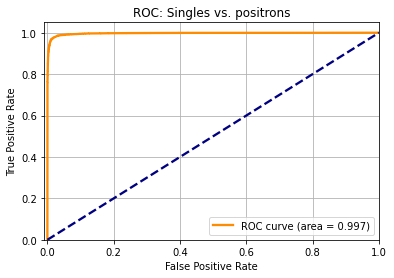

In [607]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. positrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
plt.show()

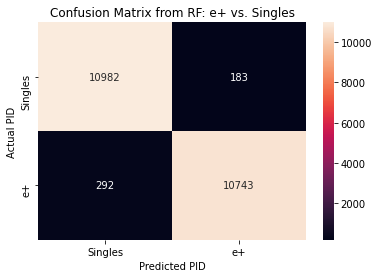

In [608]:
confmat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: e+ vs. Singles')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['Singles', 'e+'])
ax.yaxis.set_ticklabels(['Singles', 'e+'])

plt.show()

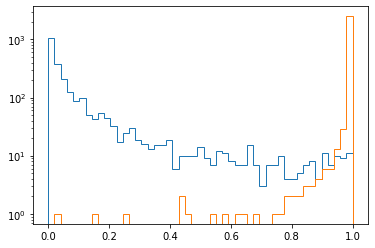

In [476]:
bins = plt.hist(regressor.predict(X_test[y_test==0]), 
         bins=np.linspace(0,1,50), histtype='step')
plt.hist(regressor.predict(X_test[y_test==1]), 
         bins=bins[1], histtype='step')
plt.yscale('log')
plt.show()

## Fast-n vs. singles

In [613]:
samples = np.min([len(singles), len(neutrons)])
data_to_manipulate = [singles[:samples], neutrons[:samples]]

In [614]:
vector_length = 100

In [643]:
X, y = prep_net_data(data_to_manipulate, prompt=False)

Running set 1 of 2
Running set 2 of 2


In [644]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [645]:
embedding_vecor_length = 64
regressor = Sequential()

regressor.add(InputLayer(input_shape=(100,5)))
regressor.add(LSTM(units=100, 
                   return_sequences=True, 
                   dropout=0.1,
                  )) #second arg seems to have huge effect. 

regressor.add(LSTM(units=100, 
                   return_sequences=False, 
                   dropout=0.1, 
                   
                  ))

regressor.add(Dense(1, activation='sigmoid'))

regressor.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [646]:
regressor.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 100, 100)          42400     
_________________________________________________________________
lstm_68 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 122,901
Trainable params: 122,901
Non-trainable params: 0
_________________________________________________________________


In [647]:
regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=3, batch_size=64, 
         )

Epoch 1/3
503/503 [==============================] - 118s 229ms/step - loss: 0.4119 - accuracy: 0.7970 - val_loss: 0.2909 - val_accuracy: 0.8845
Epoch 2/3
503/503 [==============================] - 113s 226ms/step - loss: 0.2912 - accuracy: 0.8832 - val_loss: 0.3028 - val_accuracy: 0.8776
Epoch 3/3
 33/503 [>.............................] - ETA: 1:33 - loss: 0.2943 - accuracy: 0.8745

KeyboardInterrupt: 

In [648]:
scores = regressor.predict(X_test)
y_pred = np.round(scores)

In [649]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

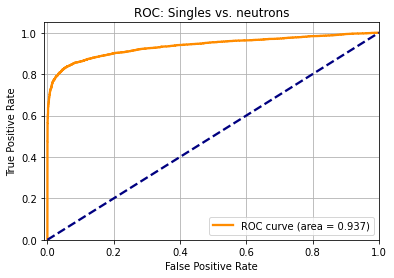

In [650]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

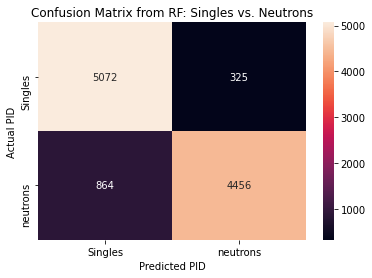

In [651]:
confmat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: Singles vs. Neutrons')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['Singles', 'neutrons'])
ax.yaxis.set_ticklabels(['Singles', 'neutrons'])

plt.show()

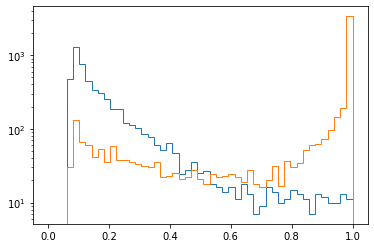

In [652]:
bins = plt.hist(regressor.predict(X_test[y_test==0]), 
         bins=np.linspace(0,1,50), histtype='step')
plt.hist(regressor.predict(X_test[y_test==1]), 
         bins=bins[1], histtype='step')
plt.yscale('log')
plt.show()

## Fast-n vs. singles vs. positrons regressor

In [653]:
samples = np.min([len(singles), len(neutrons), len(positrons)])
data_to_manipulate = [singles[:samples], positrons[:samples], neutrons[:samples]]

In [677]:
X, y = prep_net_data(data_to_manipulate, prompt=False)

Running set 1 of 3
Running set 2 of 3
Running set 3 of 3


In [678]:
a = np.array(y.astype(int))
b = np.zeros((a.size, a.max()+1), dtype='int32')
b[np.arange(a.size),a] = 1
y = b

In [679]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [680]:
embedding_vecor_length = 64
regressor = Sequential()

regressor.add(InputLayer(input_shape=(100,5)))
regressor.add(LSTM(units=100, 
                   return_sequences=True, 
                   dropout=0.2,
                  )) #second arg seems to have huge effect. 

regressor.add(LSTM(units=100, 
                   return_sequences=False, 
                   dropout=0.2, 
                   
                  ))

# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.2))

regressor.add(Dense(3, activation='softmax'))

regressor.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [681]:
regressor.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 100, 100)          42400     
_________________________________________________________________
lstm_72 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 303       
Total params: 123,103
Trainable params: 123,103
Non-trainable params: 0
_________________________________________________________________


In [682]:
regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=4, batch_size=64, 
         )

Epoch 1/4
754/754 [==============================] - 174s 227ms/step - loss: 0.7531 - accuracy: 0.6015 - val_loss: 0.5729 - val_accuracy: 0.7267
Epoch 2/4
754/754 [==============================] - 170s 226ms/step - loss: 0.5715 - accuracy: 0.7267 - val_loss: 0.5695 - val_accuracy: 0.7304
Epoch 3/4
754/754 [==============================] - 171s 226ms/step - loss: 0.5609 - accuracy: 0.7297 - val_loss: 0.5756 - val_accuracy: 0.7281
Epoch 4/4
754/754 [==============================] - 171s 226ms/step - loss: 0.5546 - accuracy: 0.7353 - val_loss: 0.5553 - val_accuracy: 0.7339


In [683]:
scores = regressor.predict(X_test)
y_pred = np.round(scores)

In [684]:
y_pred_2 = np.argmax(y_pred, axis=1)
y_test_2 = np.argmax(y_test, axis=1)

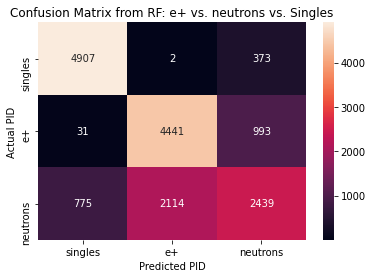

In [685]:
confmat = confusion_matrix(y_test_2, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: e+ vs. neutrons vs. Singles')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'e+', 'neutrons'])
ax.yaxis.set_ticklabels(['singles', 'e+', 'neutrons'])

plt.show()

In [686]:
prob_01 = scores[:,1][y_test_2!=2]
prob_02 = scores[:,2][y_test_2!=1]
prob_12 = scores[:,2][y_test_2!=0]

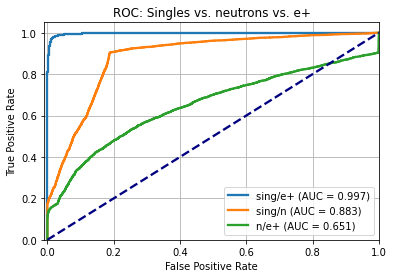

In [687]:
plt.figure()
for i, prob, label in zip([2, 1, 0], 
                          [prob_01, prob_02, prob_12], 
                          ['sing/e+', 'sing/n', 'n/e+']
                         ):
    if i==2:
        fpr, tpr, thresholds = roc_curve(y_test_2[y_test_2!=i], prob)
    else:
        fpr, tpr, thresholds = roc_curve(y_test_2[y_test_2!=i]-1, prob)
        
    auc = roc_auc_score(y_test_2[y_test_2!=i], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. neutrons vs. e+')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
plt.show()

## Fast-n vs. positrons 

In [688]:
samples = np.min([len(positrons), len(neutrons)])
data_to_manipulate = [neutrons[:samples], positrons[:samples]]

In [694]:
vector_length=150

In [703]:
X, y = prep_net_data(data_to_manipulate, prompt=True, maxlen=vector_length)

Running set 1 of 2
Running set 2 of 2


In [704]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [737]:
regressor = Sequential()

regressor.add(InputLayer(input_shape=(vector_length,5)))
regressor.add(LSTM(units=256, 
                   return_sequences=True, 
                   dropout=0.1,
                  ))  

regressor.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.1, 
                   
                  ))

regressor.add(LSTM(units=64, 
                   return_sequences=True, 
                  dropout=0.0, 
                  ))

regressor.add(LSTM(units=32, 
                   return_sequences=False, 
                  dropout=0.0, 
                  ))

# regressor.add(Dense(128, 
#                     activation='relu', 
#                    ))

# regressor.add(Dropout(0.2))

regressor.add(Dense(32, 
                   activation='relu', 
                   ))

regressor.add(Dense(1, activation='sigmoid'))

regressor.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [738]:
regressor.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 150, 256)          268288    
_________________________________________________________________
lstm_96 (LSTM)               (None, 150, 128)          197120    
_________________________________________________________________
lstm_97 (LSTM)               (None, 150, 64)           49408     
_________________________________________________________________
lstm_98 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total params: 528,321
Trainable params: 528,321
Non-trainable params: 0
_______________________________________________

In [744]:
history = regressor.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=20, batch_size=64, 
         )

Epoch 1/20
503/503 [==============================] - 376s 748ms/step - loss: 0.4782 - accuracy: 0.7642 - val_loss: 0.4950 - val_accuracy: 0.7527
Epoch 2/20
503/503 [==============================] - 375s 745ms/step - loss: 0.4734 - accuracy: 0.7672 - val_loss: 0.4929 - val_accuracy: 0.7552
Epoch 3/20
503/503 [==============================] - 376s 748ms/step - loss: 0.4721 - accuracy: 0.7694 - val_loss: 0.4923 - val_accuracy: 0.7549
Epoch 4/20
503/503 [==============================] - 376s 747ms/step - loss: 0.4692 - accuracy: 0.7720 - val_loss: 0.4954 - val_accuracy: 0.7562
Epoch 5/20
503/503 [==============================] - 375s 745ms/step - loss: 0.4675 - accuracy: 0.7733 - val_loss: 0.5102 - val_accuracy: 0.7572
Epoch 6/20
503/503 [==============================] - 376s 748ms/step - loss: 0.4649 - accuracy: 0.7745 - val_loss: 0.4942 - val_accuracy: 0.7567
Epoch 7/20
503/503 [==============================] - 376s 747ms/step - loss: 0.4607 - accuracy: 0.7776 - val_loss: 0.4958 -

In [745]:
scores = regressor.predict(X_test)
y_pred = np.round(scores)

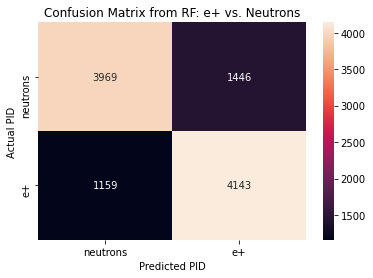

In [746]:
confmat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: e+ vs. Neutrons')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['neutrons', 'e+'])
ax.yaxis.set_ticklabels(['neutrons', 'e+'])

plt.show()

In [747]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

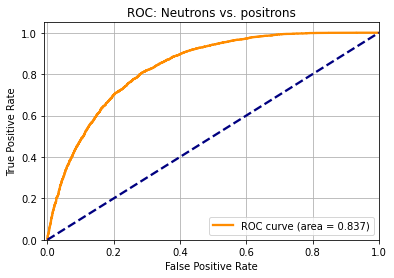

In [748]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Neutrons vs. positrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

## Compare with dense..

In [342]:
model = Sequential()
# create the model
model.add(Input(100))
model.add(Dense(200, activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(LSTM(100))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_50 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 33        
Total params: 26,665
Trainable params: 26,665
Non-trainable params: 0
_________________________________________________________________
None


In [343]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=4, batch_size=32, 
         )

Epoch 1/4
31/31 [==============================] - 1s 13ms/step - loss: 75.3347 - accuracy: 0.6782 - val_loss: 24.5491 - val_accuracy: 0.8495
Epoch 2/4
31/31 [==============================] - 0s 4ms/step - loss: 15.1592 - accuracy: 0.8757 - val_loss: 12.7255 - val_accuracy: 0.8351
Epoch 3/4
31/31 [==============================] - 0s 4ms/step - loss: 6.8806 - accuracy: 0.8535 - val_loss: 14.7000 - val_accuracy: 0.8804
Epoch 4/4
31/31 [==============================] - 0s 3ms/step - loss: 7.4078 - accuracy: 0.8882 - val_loss: 12.4183 - val_accuracy: 0.8639


In [344]:
y_pred = model.predict_classes(X_test)

/home/sophiafarrell/.local/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


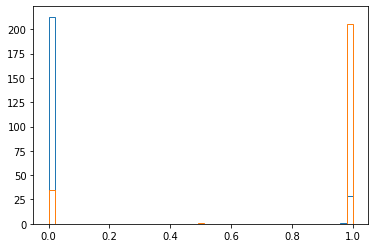

In [345]:
bins = plt.hist(model.predict(X_test[y_test==0]), 
         bins=np.linspace(0,1,50), histtype='step')
plt.hist(model.predict(X_test[y_test==1]), 
         bins=bins[1], histtype='step')
plt.show()

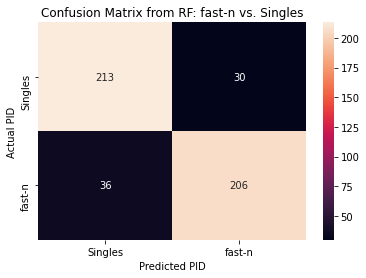

In [346]:
confmat = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: fast-n vs. Singles')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['Singles', 'fast-n'])
ax.yaxis.set_ticklabels(['Singles', 'fast-n'])

plt.show()